# Outlier Detection
> Comparison Study

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

ref: https://scikit-learn.org/stable/modules/outlier_detection.html

**Inliers are labeled 1, while outliers are labeled -1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

from alibi_detect.od import IForest

from PyNomaly import loop

2022-11-04 08:37:28.578189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 08:37:28.578216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## EbayesThresh

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [4]:
%R -o x 

In [5]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [6]:
xhat = np.array(ebayesthresh(FloatVector(x)))

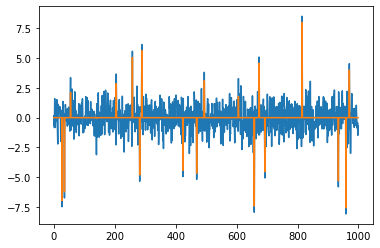

In [7]:
plt.plot(x)
plt.plot(xhat)

In [8]:
outlier_true_index = np.where(xhat!=0)

In [9]:
outlier_true_index

(array([ 27,  35,  55, 140, 205, 258, 282, 289, 424, 469, 494, 606, 658,
        674, 693, 815, 934, 959, 970]),)

In [10]:
outlier_true_value = xhat[xhat!=0]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [11]:
outlier_true_one = xhat

In [12]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## sklearn.neighbors.LocalOutlierFactor

### 1. linear

In [13]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [14]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [15]:
_df1=pd.DataFrame({'x':_x, 'y':_y})

---

In [16]:
X = np.array(_df)

In [17]:
clf = LocalOutlierFactor(n_neighbors=2)

In [18]:
clf.fit_predict(X)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1

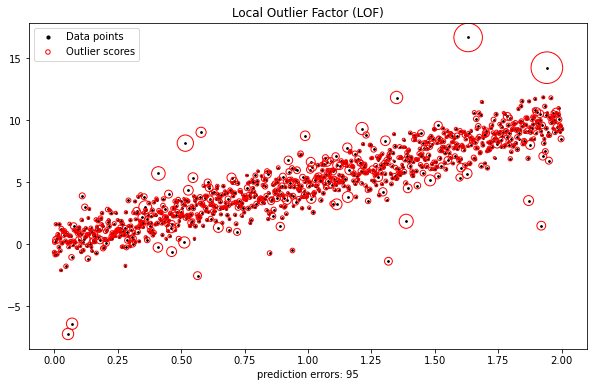

In [19]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [20]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [21]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [22]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [23]:
w=np.zeros((1000,1000))

In [24]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [25]:
_simul = SIMUL(_df)

In [26]:
_simul.fit()

In [27]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [28]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [29]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [30]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

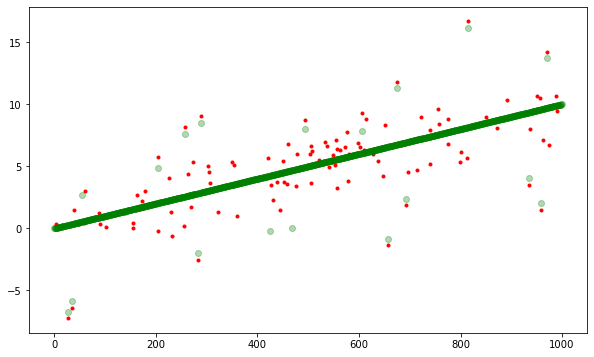

In [31]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

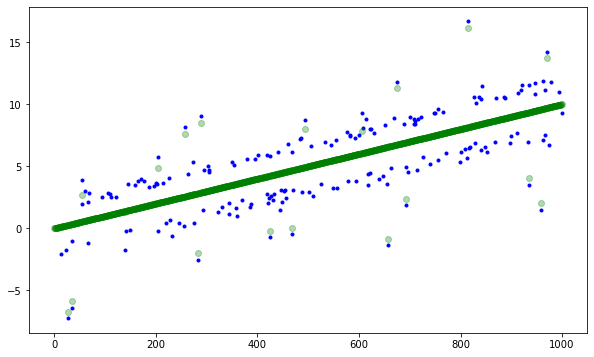

In [32]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [33]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 106, 180)

In [34]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 15 개 detecting


In [35]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.7894736842105263

In [36]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [37]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [38]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

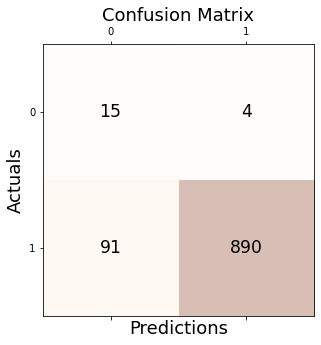

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [40]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7894736842105263

In [41]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.905
Precision: 0.996
Recall: 0.907
F1 Score: 0.949


In [42]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

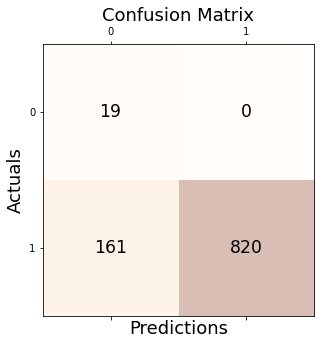

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [44]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [45]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.839
Precision: 1.000
Recall: 0.836
F1 Score: 0.911


### 2. linear(2)

In [46]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [47]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [48]:
_df2=pd.DataFrame({'x':_x, 'y':_y})

---

In [49]:
X = np.array(_df)

In [50]:
clf = LocalOutlierFactor(n_neighbors=2)

In [51]:
clf.fit_predict(X)

array([-1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

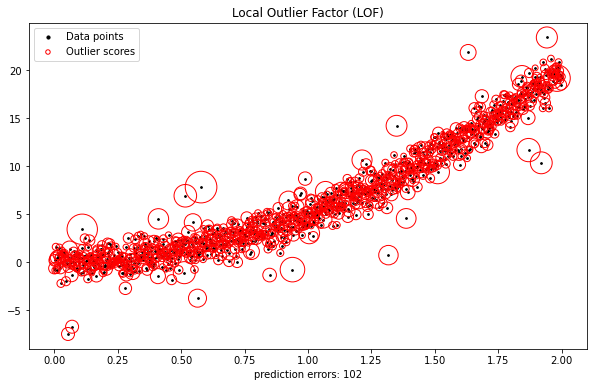

In [52]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [53]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [54]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [55]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [56]:
w=np.zeros((1000,1000))

In [57]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [58]:
_simul = SIMUL(_df)

In [59]:
_simul.fit()

In [60]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [61]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [62]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [63]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

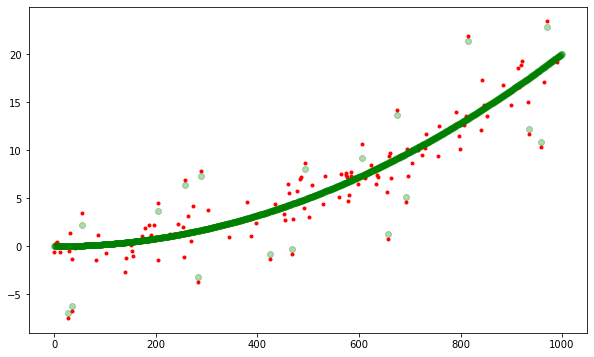

In [64]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

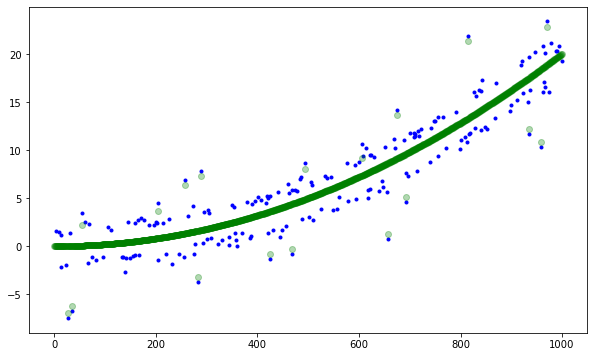

In [65]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [66]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 121, 191)

In [67]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [68]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [69]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [70]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [71]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

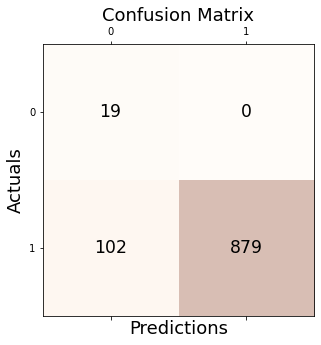

In [72]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [73]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [74]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.898
Precision: 1.000
Recall: 0.896
F1 Score: 0.945


In [75]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

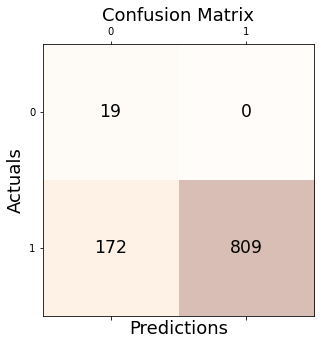

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [77]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [78]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.828
Precision: 1.000
Recall: 0.825
F1 Score: 0.904


### 3. sin

In [79]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [80]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [81]:
_df3=pd.DataFrame({'x':_x, 'y':_y})

---

In [82]:
X = np.array(_df)

In [83]:
clf = LocalOutlierFactor(n_neighbors=2)

In [84]:
clf.fit_predict(X)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

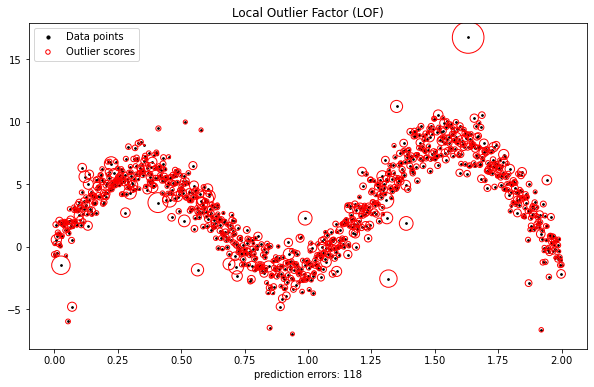

In [85]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [86]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [87]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [88]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [89]:
w=np.zeros((1000,1000))

In [90]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [91]:
_simul = SIMUL(_df)

In [92]:
_simul.fit()

In [93]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [94]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [95]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [96]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

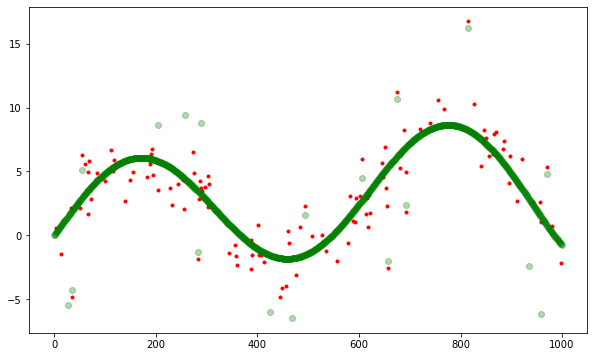

In [97]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

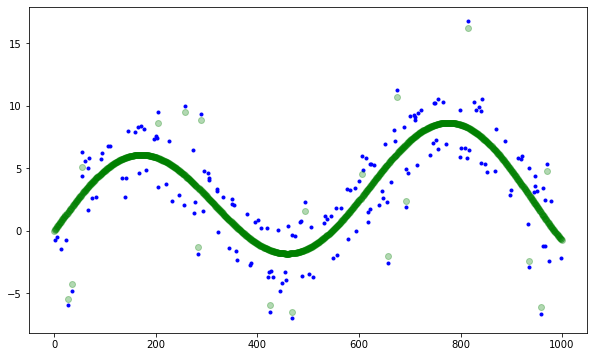

In [98]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [99]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 121, 179)

In [100]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 11 개 detecting


In [101]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.5789473684210527

In [102]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [103]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [104]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

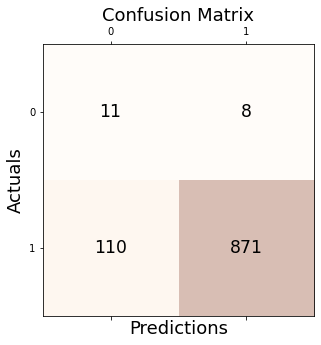

In [105]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [106]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.5789473684210527

In [107]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.882
Precision: 0.991
Recall: 0.888
F1 Score: 0.937


In [108]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

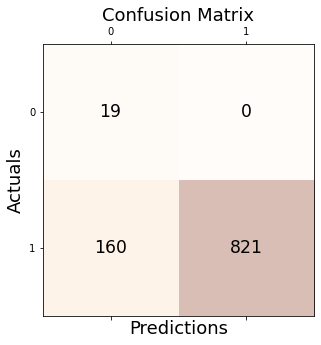

In [109]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [110]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [111]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.840
Precision: 1.000
Recall: 0.837
F1 Score: 0.911


### 4. cosin

In [112]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [113]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [114]:
_df4=pd.DataFrame({'x':_x, 'y':_y})

---

In [115]:
X = np.array(_df)

In [116]:
clf = LocalOutlierFactor(n_neighbors=2)

In [117]:
clf.fit_predict(X)

array([ 1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
        1,  1, -1,  1,  1

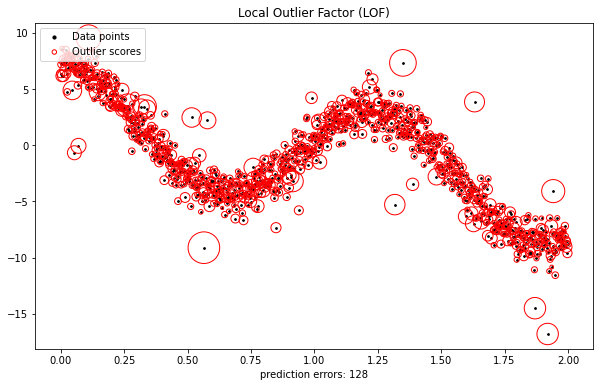

In [118]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [119]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [120]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [121]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [122]:
w=np.zeros((1000,1000))

In [123]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [124]:
_simul = SIMUL(_df)

In [125]:
_simul.fit()

In [126]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [127]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [128]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [129]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

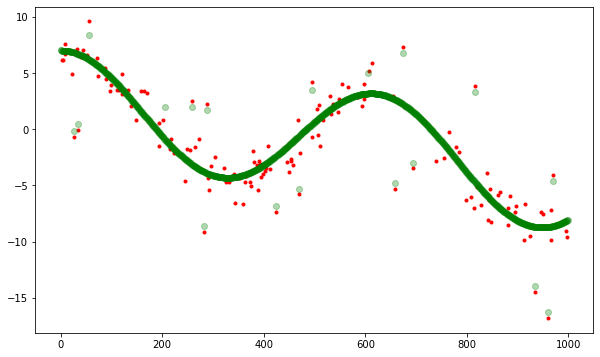

In [130]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

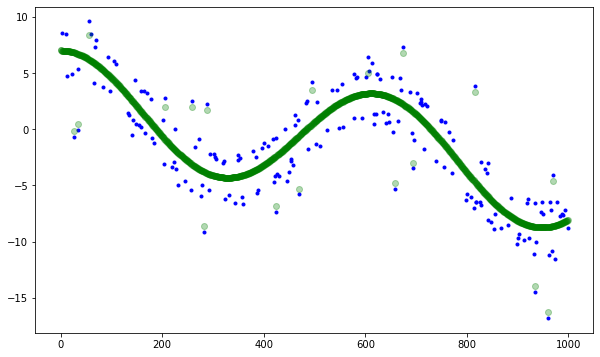

In [131]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [132]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 141, 194)

In [133]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 16 개 detecting


In [134]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.8421052631578947

In [135]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [136]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [137]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

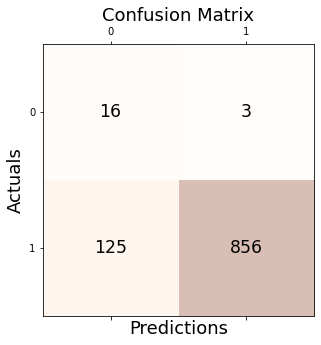

In [138]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [139]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.8421052631578947

In [140]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.872
Precision: 0.997
Recall: 0.873
F1 Score: 0.930


In [141]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

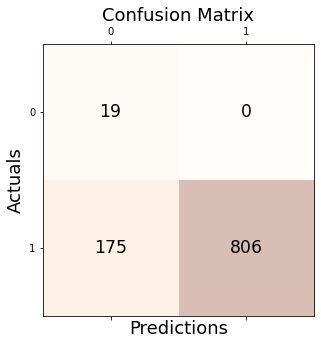

In [142]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [143]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [144]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.825
Precision: 1.000
Recall: 0.822
F1 Score: 0.902


### 5. One dimensional manifold

In [145]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [146]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [147]:
_df5=pd.DataFrame({'x':_x, 'y':_y, 'f':f})

---

In [148]:
X = np.array(_df)

In [149]:
clf = LocalOutlierFactor(n_neighbors=2)

In [150]:
clf.fit_predict(X)

array([ 1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1

<Figure size 720x432 with 0 Axes>

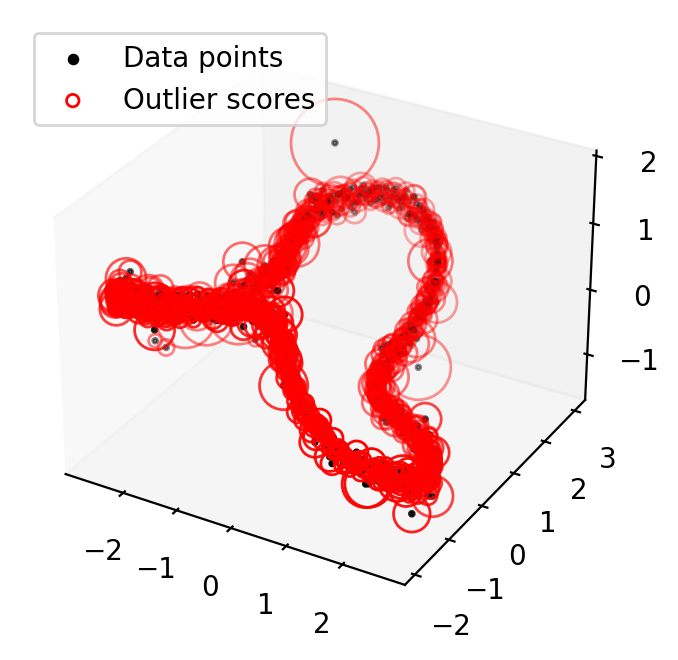

In [151]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
# ax.title("Local Outlier Factor (LOF)")
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
ax.scatter3D(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
ax.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# ax.xlabel("prediction errors: %d" % (n_errors))
legend = ax.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
# ax.show()

outlier

In [152]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [153]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [154]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=60): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [155]:
_simul = SIMUL(_df)

In [156]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 540.10it/s]


In [157]:
_simul.get_weightmatrix(theta=(_simul.D[_simul.D>0].mean()),kappa=2500) 

In [158]:
_simul.fit()

In [159]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [160]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [161]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [162]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

In [163]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 129, 205)

In [164]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 14 개 detecting


In [165]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.7368421052631579

In [166]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [167]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [168]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=vx,
#     y=vy,
#     z=f,
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=f,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.2
#     )
# )])
# fig.add_scatter3d(x=_df.loc[outlier_first_index]['x'],y=_df.loc[outlier_first_index]['y'],z=_df.loc[outlier_first_index]['f'], mode="markers",marker=dict(size=3, color="blue"),name='f',opacity=0.5)
# fig.add_trace(go.Scatter3d(x=vx,y=vy,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene = dict(xaxis = dict(range=[-3,3],),
#                                          yaxis = dict(range=[-3,3],),
#                                          zaxis = dict(range=[-10,10],),),width=800,height=800,autosize=False)
# fig.show()

In [169]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=vx,
#     y=vy,
#     z=f,
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=f,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.2
#     )
# )])
# fig.add_scatter3d(x=_simul.df.loc[outlier_simul_first_index]['x'],y=_simul.df.loc[outlier_simul_first_index]['y'],z=_simul.df.loc[outlier_simul_first_index]['f'], mode="markers",marker=dict(size=3, color="red"),name='f',opacity=0.5)
# fig.add_trace(go.Scatter3d(x=vx,y=vy,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene = dict(xaxis = dict(range=[-3,3],),
#                                          yaxis = dict(range=[-3,3],),
#                                          zaxis = dict(range=[-10,10],),),width=800,height=800,autosize=False)
# fig.show()

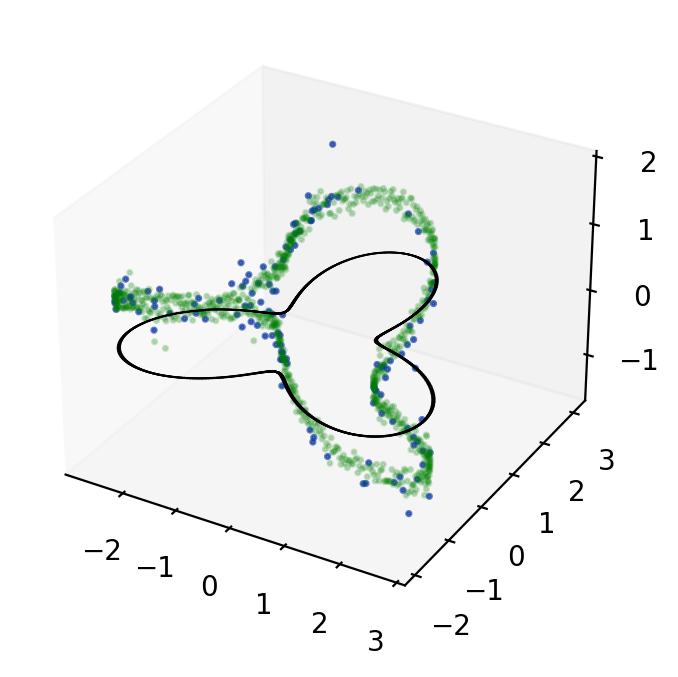

In [170]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_df.loc[outlier_first_index]['x'],_df.loc[outlier_first_index]['y'],_df.loc[outlier_first_index]['f'], zdir='z',s=10,marker='.',c='blue',alpha=0.5)
ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

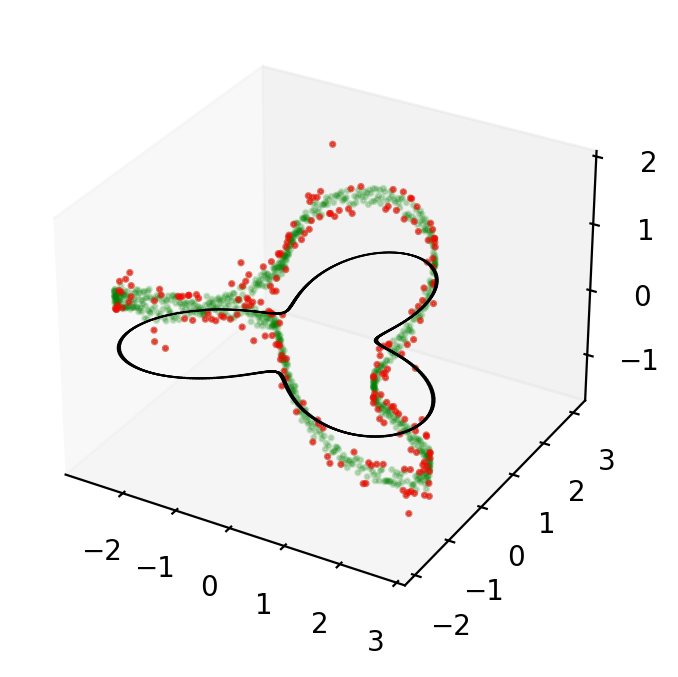

In [171]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_simul.df.loc[outlier_simul_first_index]['x'],_simul.df.loc[outlier_simul_first_index]['y'],_simul.df.loc[outlier_simul_first_index]['f'], zdir='z',s=10,marker='.',c='red',alpha=0.5)
ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

In [172]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

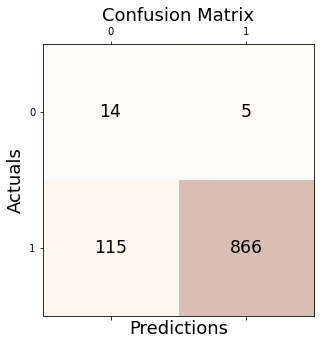

In [173]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [174]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7368421052631579

In [175]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.880
Precision: 0.994
Recall: 0.883
F1 Score: 0.935


In [176]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

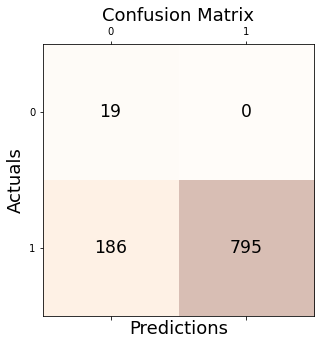

In [177]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [178]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [179]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.814
Precision: 1.000
Recall: 0.810
F1 Score: 0.895


### 6. Bunny(Two dimensional manifold)

In [180]:
G = graphs.Bunny()
n = G.N

In [181]:
g = filters.Heat(G, tau=75) 

In [182]:
np.random.seed(1)
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 

In [183]:
outlier_true_index_2 = np.where(noise>1)

In [184]:
outlier_true_value_2 = noise[noise>1]

In [185]:
outlier_true_one_2 = noise

In [186]:
outlier_true_one_2 = list(map(lambda x: -1 if x > 1 else 1,outlier_true_one_2))

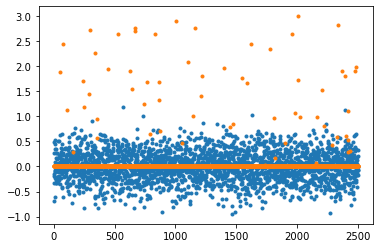

In [187]:
plt.plot(normal,'.')
plt.plot(unif,'.')
#plt.plot(noise,'--')

In [188]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-11-04 08:37:40,218:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [189]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = G.coords[:,2]

In [190]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'f' : f, 'noise' : noise})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [191]:
_df6=pd.DataFrame({'x':_x, 'y':_y,'z' : _z, 'f' : f, 'noise' : noise})

---

In [192]:
X = np.array(_df)

In [193]:
clf = LocalOutlierFactor(n_neighbors=2)

In [194]:
clf.fit_predict(X[:,:4])

array([1, 1, 1, ..., 1, 1, 1])

<Figure size 720x432 with 0 Axes>

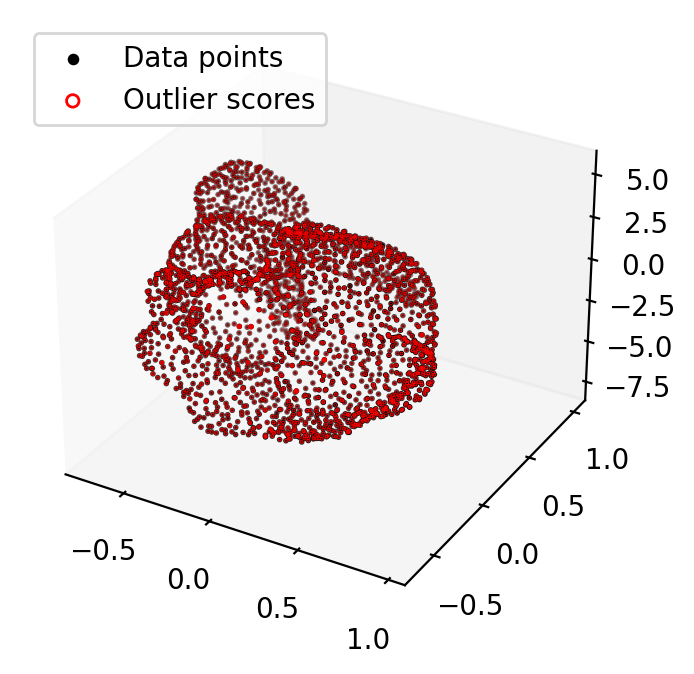

In [195]:
ground_truth=outlier_true_one_2
y_pred = clf.fit_predict(X[:,:4])
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
# ax.title("Local Outlier Factor (LOF)")
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], color="k", s=1.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
ax.scatter3D(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    s=1 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
ax.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# ax.xlabel("prediction errors: %d" % (n_errors))
legend = ax.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
# ax.show()

outlier

In [196]:
outlier_first_index = np.where(clf.fit_predict(X[:,:4])==-1)

In [197]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X[:,:4])==-1]

In [198]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [199]:
_simul = SIMUL(_df)

In [200]:
_simul.fit()

In [201]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [202]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [203]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [204]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

In [205]:
len(outlier_true_value_2),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(43, 33, 32)

In [206]:
print(len(outlier_true_value_2),"개 outlier 중에",len(np.intersect1d(outlier_true_index_2,outlier_first_index)),"개 detecting")

43 개 outlier 중에 0 개 detecting


In [207]:
len(np.intersect1d(outlier_true_index_2,outlier_first_index))/len(np.array(outlier_true_index_2).tolist()[0])

0.0

In [208]:
print(len(outlier_true_value_2),"개 outlier 중에",len(np.intersect1d(outlier_true_index_2,outlier_simul_first_index)),"개 detecting")

43 개 outlier 중에 31 개 detecting


In [209]:
len(np.intersect1d(outlier_true_index_2,outlier_simul_first_index))/len(np.array(outlier_true_index_2).tolist()[0])

0.7209302325581395

In [210]:
# fig = px.scatter_3d(x=_simul.df.query('Residual**2>6')['x'],y=_simul.df.query('Residual**2>6')['y'],z=_simul.df.query('Residual**2>6')['z'],
#                     color=_simul.df.query('Residual**2>6')['fnoise'],
#                     opacity=1,
#                     height=400,
#                     size=abs(_simul.df.query('Residual**2>6')['fnoise']),
#                     range_color=[-1,5],
#                     color_continuous_scale='jet')
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker=dict(line=dict(width=0)))

In [211]:
conf_matrix = confusion_matrix(outlier_true_one_2, clf.fit_predict(X[:,:4]))

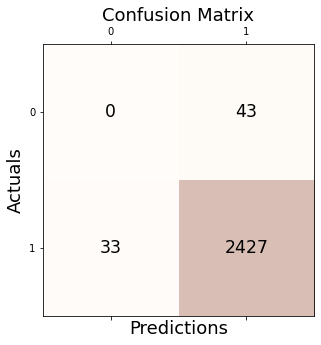

In [212]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [213]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.0

In [214]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Precision: %.3f' % precision_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Recall: %.3f' % recall_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))

Accuracy: 0.970
Precision: 0.983
Recall: 0.987
F1 Score: 0.985


In [215]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_simul_one)

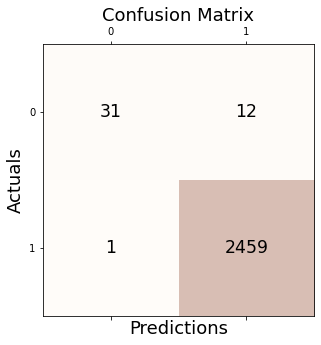

In [216]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [217]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7209302325581395

In [218]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_simul_one))

Accuracy: 0.995
Precision: 0.995
Recall: 1.000
F1 Score: 0.997


---

## Python Outlier Detection(PYOD)

contamination =0.05
- 5%의 이상치 감지

In [219]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
import seaborn as sns

### 1.

In [220]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [221]:
_df=pd.DataFrame({'x':_x, 'y':_y})

ABOD(Angle Based Techniques Outlier Detection)

In [222]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [223]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

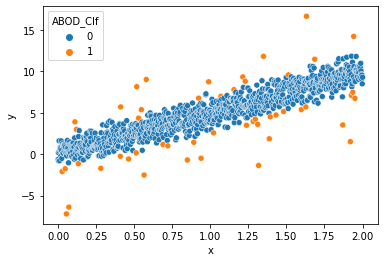

In [224]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

<AxesSubplot:xlabel='x', ylabel='y'>

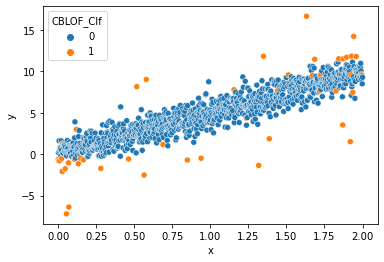

In [225]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'CBLOF_Clf')

In [226]:
outlier_ABOD_one = list(abod_clf.labels_)

In [227]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [228]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

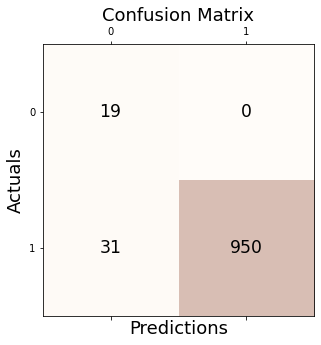

In [229]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [230]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [231]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.969
Precision: 1.000
Recall: 0.968
F1 Score: 0.984


### 2.

In [232]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [233]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [234]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [235]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

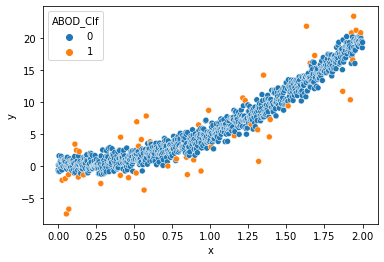

In [236]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

<AxesSubplot:xlabel='x', ylabel='y'>

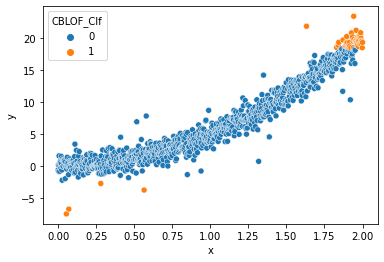

In [237]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'CBLOF_Clf')

In [238]:
outlier_ABOD_one = list(abod_clf.labels_)

In [239]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [240]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

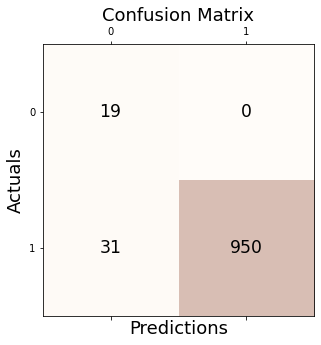

In [241]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [242]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [243]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.969
Precision: 1.000
Recall: 0.968
F1 Score: 0.984


### 3.

In [244]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [245]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [246]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [247]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

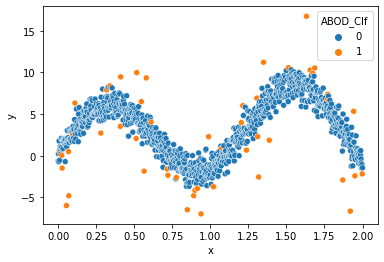

In [248]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

<AxesSubplot:xlabel='x', ylabel='y'>

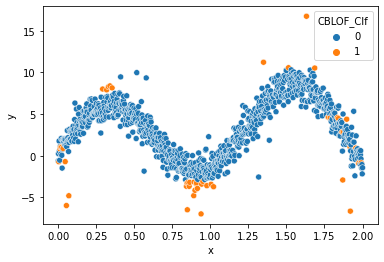

In [249]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'CBLOF_Clf')

In [250]:
outlier_ABOD_one = list(abod_clf.labels_)

In [251]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [252]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

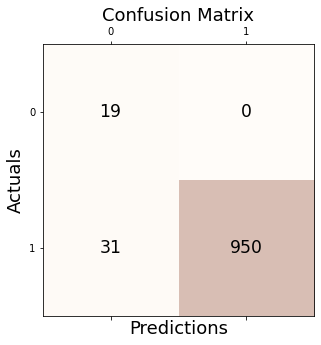

In [253]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [254]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [255]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.969
Precision: 1.000
Recall: 0.968
F1 Score: 0.984


### 4. 

In [256]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [257]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [258]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [259]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

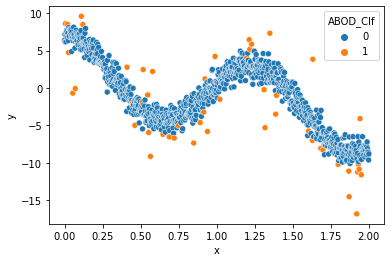

In [260]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

<AxesSubplot:xlabel='x', ylabel='y'>

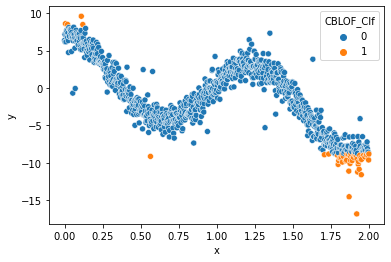

In [261]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'CBLOF_Clf')

In [262]:
outlier_ABOD_one = list(abod_clf.labels_)

In [263]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [264]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

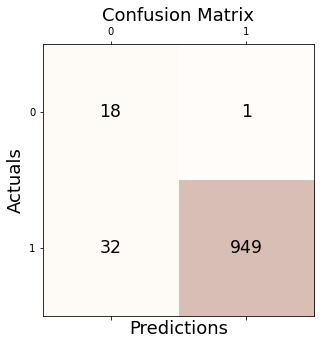

In [265]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [266]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.9473684210526315

In [267]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.967
Precision: 0.999
Recall: 0.967
F1 Score: 0.983


### 5.

In [268]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [269]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [270]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y','f']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [271]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y', 'f']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

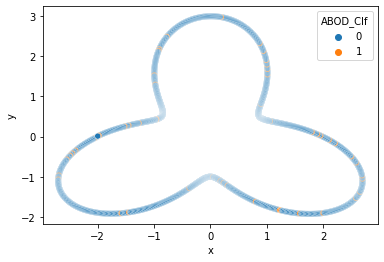

In [272]:
sns.scatterplot(data = _df, x = 'x', y = 'y',hue = 'ABOD_Clf')

<AxesSubplot:xlabel='x', ylabel='y'>

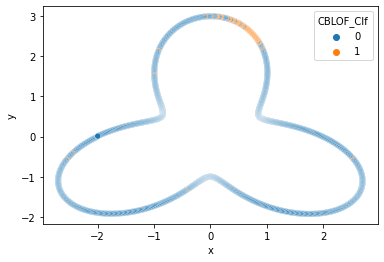

In [273]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'CBLOF_Clf')

In [274]:
outlier_ABOD_one = list(abod_clf.labels_)

In [275]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [276]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

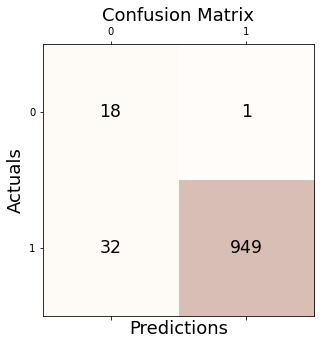

In [277]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [278]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.9473684210526315

In [279]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.967
Precision: 0.999
Recall: 0.967
F1 Score: 0.983


### 6.

In [280]:
G = graphs.Bunny()
n = G.N

In [281]:
g = filters.Heat(G, tau=75) 

In [282]:
np.random.seed(1)
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 

In [283]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-11-04 08:37:46,011:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [284]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = G.coords[:,2]

In [285]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'f' : f + noise})

In [286]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y', 'z','f']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [287]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y','z','f']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

In [288]:
outlier_ABOD_one = list(abod_clf.labels_)

In [289]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [290]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_ABOD_one)

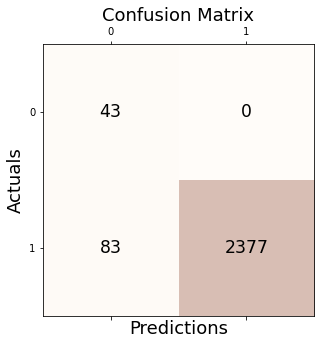

In [291]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [292]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [293]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_ABOD_one))

Accuracy: 0.967
Precision: 1.000
Recall: 0.966
F1 Score: 0.983


---

##  alibi-detect

### 1.

In [294]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [295]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [296]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [297]:
od.fit(_df[['x', 'y']])

In [298]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

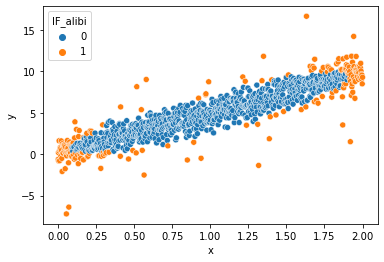

In [299]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [300]:
outlier_alibi_one = _df['IF_alibi']

In [301]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [302]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

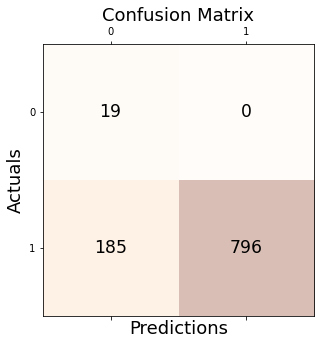

In [303]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [304]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [305]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.815
Precision: 1.000
Recall: 0.811
F1 Score: 0.896


### 2.

In [306]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [307]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [308]:
od.fit(_df[['x', 'y']])

In [309]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

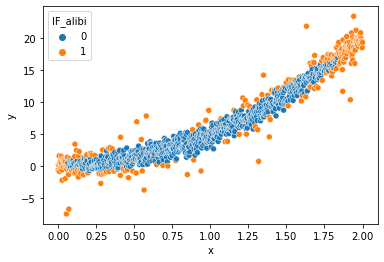

In [310]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [311]:
outlier_alibi_one = _df['IF_alibi']

In [312]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [313]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

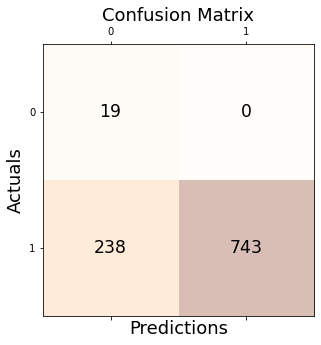

In [314]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [315]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [316]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.762
Precision: 1.000
Recall: 0.757
F1 Score: 0.862


### 3.

In [317]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [318]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [319]:
od.fit(_df[['x', 'y']])

In [320]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

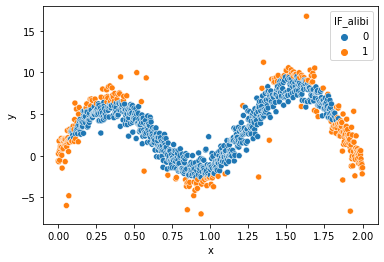

In [321]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [322]:
outlier_alibi_one = _df['IF_alibi']

In [323]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [324]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

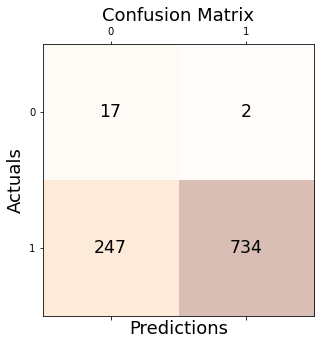

In [325]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [326]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.8947368421052632

In [327]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.751
Precision: 0.997
Recall: 0.748
F1 Score: 0.855


### 4. 

In [328]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [329]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [330]:
od.fit(_df[['x', 'y']])

In [331]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

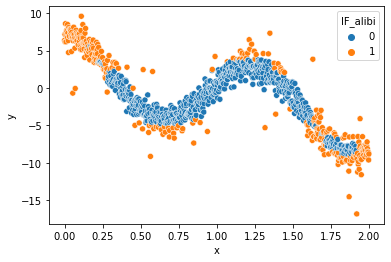

In [332]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [333]:
outlier_alibi_one = _df['IF_alibi']

In [334]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [335]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

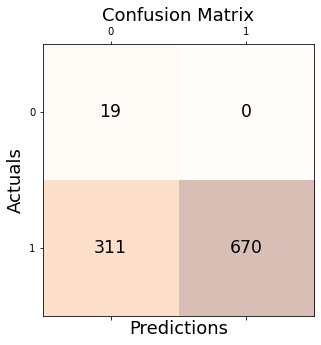

In [336]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [337]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [338]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.689
Precision: 1.000
Recall: 0.683
F1 Score: 0.812


### 5.

In [339]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [340]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [341]:
od.fit(_df[['x', 'y','f']])

In [342]:
preds = od.predict(
    _df[['x', 'y','f']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

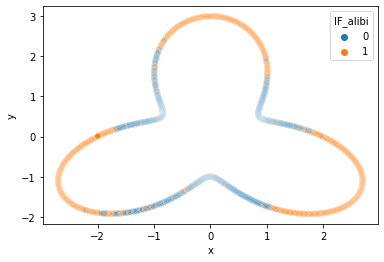

In [343]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [344]:
outlier_alibi_one = _df['IF_alibi']

In [345]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [346]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

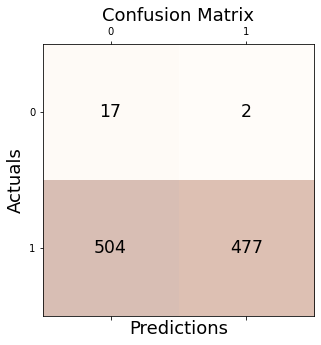

In [347]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [348]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.8947368421052632

In [349]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.494
Precision: 0.996
Recall: 0.486
F1 Score: 0.653


### 6.

In [350]:
G = graphs.Bunny()
n = G.N

In [351]:
g = filters.Heat(G, tau=75) 

In [352]:
np.random.seed(1)
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 

In [353]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-11-04 08:37:49,371:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [354]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = G.coords[:,2]

In [355]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'f' : f + noise})

In [356]:
od.fit(_df[['x', 'y','z','f']])

In [357]:
preds = od.predict(
    _df[['x', 'y','z','f']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

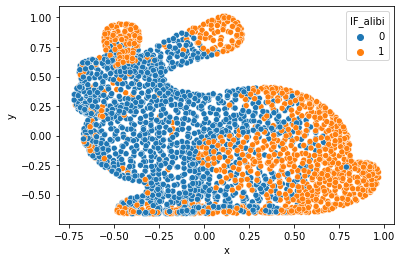

In [358]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [359]:
outlier_alibi_one = _df['IF_alibi']

In [360]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [361]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_alibi_one)

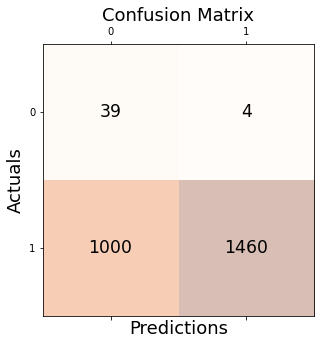

In [362]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [363]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.9069767441860465

In [364]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_alibi_one))

Accuracy: 0.599
Precision: 0.997
Recall: 0.593
F1 Score: 0.744


## PyNomaly

### 1.

In [365]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [366]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [367]:
m = loop.LocalOutlierProbability(_df[['x', 'y']], use_numba=True, progress_bar=True).fit()
scores = m.local_outlier_probabilities

[ ==================================================================================== ] 100.00%

<AxesSubplot:xlabel='x', ylabel='y'>

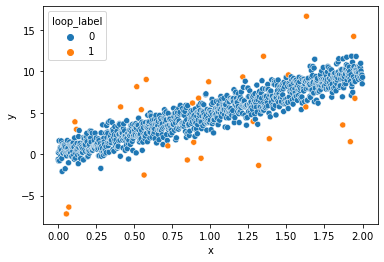

In [368]:
_df['loop_score'] = scores
_df['loop_label'] = _df['loop_score'].apply(lambda x: 1 if x >0.5 else 0)
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'loop_label')

In [369]:
outlier_PyNomaly_one = _df['loop_label']

In [370]:
outlier_PyNomaly_one = list(map(lambda x: 1 if x==0  else -1,outlier_PyNomaly_one))

In [371]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_PyNomaly_one)

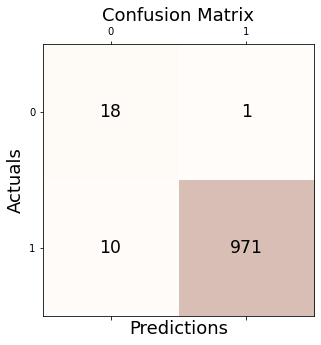

In [372]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [373]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.9473684210526315

In [374]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_PyNomaly_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_PyNomaly_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_PyNomaly_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_PyNomaly_one))

Accuracy: 0.989
Precision: 0.999
Recall: 0.990
F1 Score: 0.994


### 2.

In [375]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [376]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [377]:
m = loop.LocalOutlierProbability(_df[['x', 'y']], use_numba=True, progress_bar=True).fit()
scores = m.local_outlier_probabilities

[ ==================================================================================== ] 100.00%

<AxesSubplot:xlabel='x', ylabel='y'>

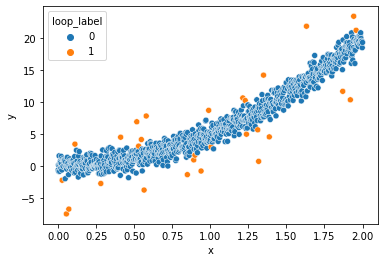

In [378]:
_df['loop_score'] = scores
_df['loop_label'] = _df['loop_score'].apply(lambda x: 1 if x >0.5 else 0)
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'loop_label')

In [379]:
outlier_PyNomaly_one = _df['loop_label']

In [380]:
outlier_PyNomaly_one = list(map(lambda x: 1 if x==0  else -1,outlier_PyNomaly_one))

In [381]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_PyNomaly_one)

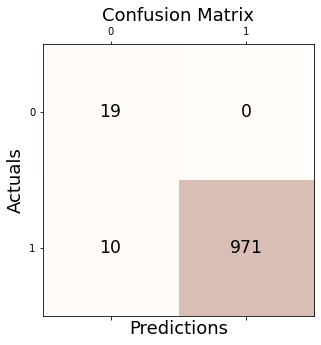

In [382]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [383]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [384]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_PyNomaly_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_PyNomaly_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_PyNomaly_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_PyNomaly_one))

Accuracy: 0.990
Precision: 1.000
Recall: 0.990
F1 Score: 0.995


### 3.

In [385]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [386]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [387]:
m = loop.LocalOutlierProbability(_df[['x', 'y']], use_numba=True, progress_bar=True).fit()
scores = m.local_outlier_probabilities

[ ==================================================================================== ] 100.00%

<AxesSubplot:xlabel='x', ylabel='y'>

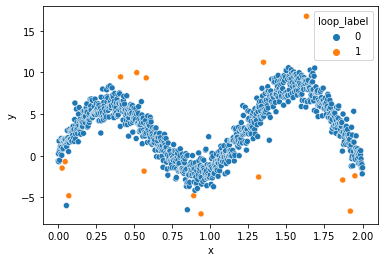

In [388]:
_df['loop_score'] = scores
_df['loop_label'] = _df['loop_score'].apply(lambda x: 1 if x >0.5 else 0)
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'loop_label')

In [389]:
outlier_PyNomaly_one = _df['loop_label']

In [390]:
outlier_PyNomaly_one = list(map(lambda x: 1 if x==0  else -1,outlier_PyNomaly_one))

In [391]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_PyNomaly_one)

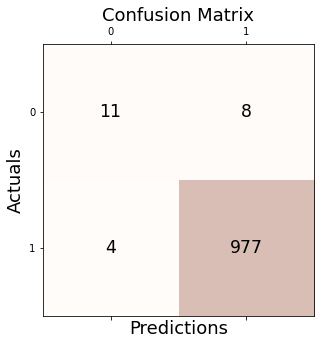

In [392]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [393]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.5789473684210527

In [394]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_PyNomaly_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_PyNomaly_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_PyNomaly_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_PyNomaly_one))

Accuracy: 0.988
Precision: 0.992
Recall: 0.996
F1 Score: 0.994


### 4. 

In [395]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [396]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [397]:
m = loop.LocalOutlierProbability(_df[['x', 'y']], use_numba=True, progress_bar=True).fit()
scores = m.local_outlier_probabilities

[ ==================================================================================== ] 100.00%

<AxesSubplot:xlabel='x', ylabel='y'>

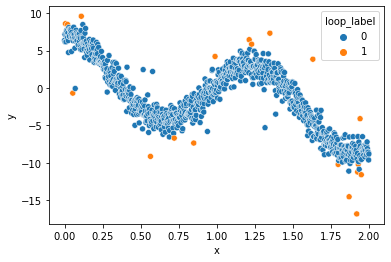

In [398]:
_df['loop_score'] = scores
_df['loop_label'] = _df['loop_score'].apply(lambda x: 1 if x >0.5 else 0)
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'loop_label')

In [399]:
outlier_PyNomaly_one = _df['loop_label']

In [400]:
outlier_PyNomaly_one = list(map(lambda x: 1 if x==0  else -1,outlier_PyNomaly_one))

In [401]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_PyNomaly_one)

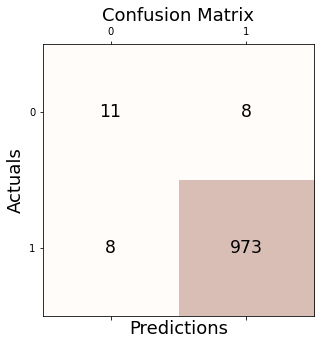

In [402]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [403]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.5789473684210527

In [404]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_PyNomaly_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_PyNomaly_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_PyNomaly_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_PyNomaly_one))

Accuracy: 0.984
Precision: 0.992
Recall: 0.992
F1 Score: 0.992


### 5.

In [405]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [406]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [407]:
m = loop.LocalOutlierProbability(_df[['x', 'y', 'f']], use_numba=True, progress_bar=True).fit()
scores = m.local_outlier_probabilities

[ ==================================================================================== ] 100.00%

<AxesSubplot:xlabel='x', ylabel='y'>

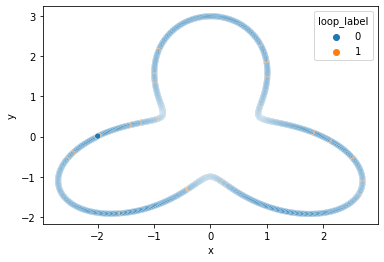

In [408]:
_df['loop_score'] = scores
_df['loop_label'] = _df['loop_score'].apply(lambda x: 1 if x >0.5 else 0)
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'loop_label')

In [409]:
outlier_PyNomaly_one = _df['loop_label']

In [410]:
outlier_PyNomaly_one = list(map(lambda x: 1 if x==0  else -1,outlier_PyNomaly_one))

In [411]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_PyNomaly_one)

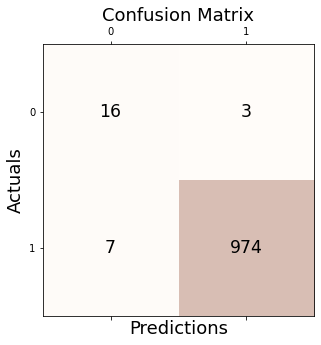

In [412]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [413]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.8421052631578947

In [414]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_PyNomaly_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_PyNomaly_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_PyNomaly_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_PyNomaly_one))

Accuracy: 0.990
Precision: 0.997
Recall: 0.993
F1 Score: 0.995


### 6.

In [415]:
G = graphs.Bunny()
n = G.N

In [416]:
g = filters.Heat(G, tau=75) 

In [417]:
np.random.seed(1)
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 

In [418]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-11-04 08:37:55,401:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [419]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = G.coords[:,2]

In [420]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'f' : f + noise})

In [421]:
m = loop.LocalOutlierProbability(_df[['x', 'y','z','f']], use_numba=True, progress_bar=True).fit()
scores = m.local_outlier_probabilities

[ ================================================================================= ] 100.00%

<AxesSubplot:xlabel='x', ylabel='y'>

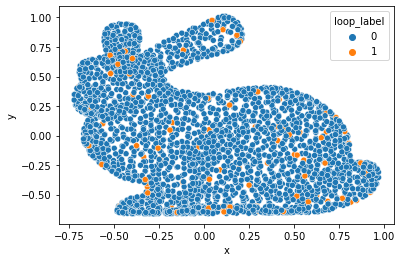

In [422]:
_df['loop_score'] = scores
_df['loop_label'] = _df['loop_score'].apply(lambda x: 1 if x >0.5 else 0)
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'loop_label')

In [423]:
outlier_PyNomaly_one = _df['loop_label']

In [424]:
outlier_PyNomaly_one = list(map(lambda x: 1 if x==0  else -1,outlier_PyNomaly_one))

In [425]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_PyNomaly_one)

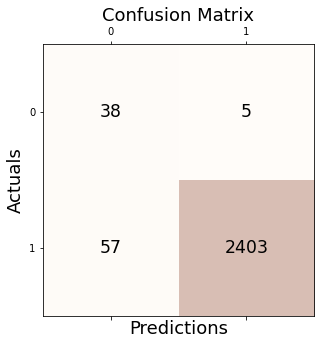

In [426]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [427]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.8837209302325582

In [428]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_PyNomaly_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_PyNomaly_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_PyNomaly_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_PyNomaly_one))

Accuracy: 0.975
Precision: 0.998
Recall: 0.977
F1 Score: 0.987


---

## Circle

### 1.

In [429]:
Nsample = 1000
xx = np.random.normal(size=Nsample)
yy = np.random.normal(size=Nsample)

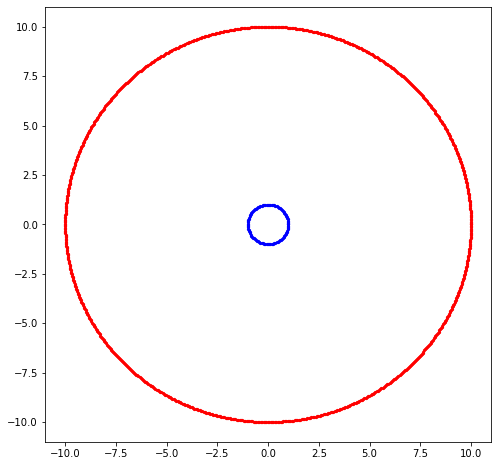

In [430]:
n_dots = 900   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots) 
xs, ys = [], []    # for coordinates of points to plot
ra = 10.0          # radius of circle

for ang in angs:
    # compute (x,y) for each point
    xss = 0+ra*np.cos(ang)
    yss = 0+ra*np.sin(ang)
    xs.append(xss)   # collect x
    ys.append(yss)   # collect y

n_dots1 = 100   # set number of dots
angs1 = np.linspace(0, 2*np.pi, n_dots1) 
xs1, ys1 = [], []    # for coordinates of points to plot
ra1 = 1.0          # radius of circle

for ang1 in angs1:
    # compute (x,y) for each point
    xss1 = 0+ra1*np.cos(ang1)
    yss1 = 0+ra1*np.sin(ang1)
    xs1.append(xss1)   # collect x
    ys1.append(yss1)   # collect y
    
fig = plt.figure(figsize=(8, 8))
plt.scatter(xs, ys, c = 'red', s=5)  # plot points 
plt.scatter(xs1, ys1, c = 'blue', s=5)  # plot points 
plt.show()

In [431]:
_x = xs + xs1
_y = ys + ys1

In [432]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [433]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [434]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

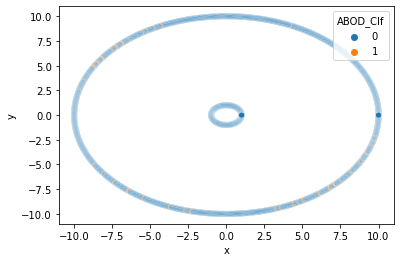

In [435]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

<AxesSubplot:xlabel='x', ylabel='y'>

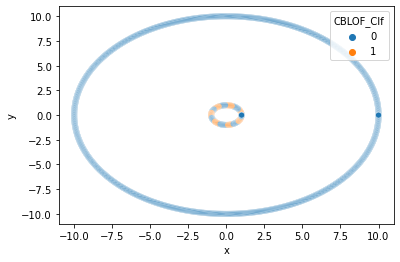

In [436]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'CBLOF_Clf')

In [437]:
outlier_ABOD_one = list(abod_clf.labels_)

In [438]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [439]:
np.array(list(abod_clf.labels_)).sum()

49

In [440]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [441]:
w=np.zeros((1000,1000))

In [442]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [443]:
_simul = SIMUL(_df)

In [444]:
_simul.fit()

In [445]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>0.55').reset_index()['index'])

In [446]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>0.55').reset_index()['y'])

In [447]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [448]:
outlier_simul_one = list(map(lambda x: -1 if x > 0.55 else 1,outlier_simul_one))

In [449]:
_simul.df=_simul.df.assign(one = outlier_simul_one)

<AxesSubplot:xlabel='x', ylabel='y'>

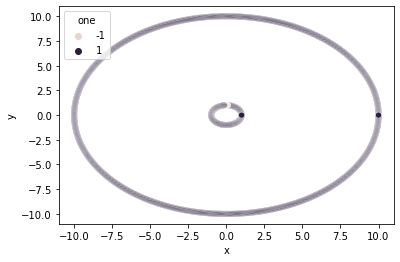

In [450]:
sns.scatterplot(data = _simul.df, x = 'x', y = 'y', hue = 'one')

In [451]:
len(_simul.df.iloc[outlier_simul_first_index])

7

(-11.0, 11.0)

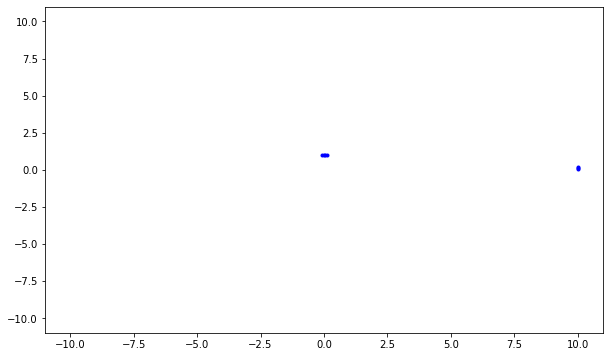

In [452]:
plt.figure(figsize=(10,6))
plt.plot(_simul.df.iloc[outlier_simul_first_index]['x'],_simul.df.iloc[outlier_simul_first_index]['y'],'b.')
plt.xlim(-11,11)
plt.ylim(-11,11)
# plt.plot(xhat,'go',alpha=0.3)

In [453]:
conf_matrix = confusion_matrix(outlier_simul_one, outlier_ABOD_one)

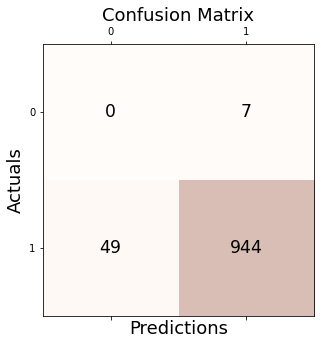

In [454]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [455]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.0

In [456]:
print('Accuracy: %.3f' % accuracy_score(outlier_simul_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_simul_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_simul_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_simul_one, outlier_ABOD_one))

Accuracy: 0.944
Precision: 0.993
Recall: 0.951
F1 Score: 0.971


### 2.alibi-detect

In [457]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [458]:
od.fit(_df[['x', 'y']])

In [459]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

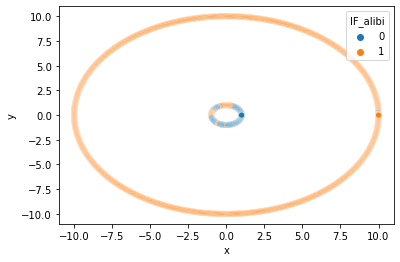

In [460]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [461]:
outlier_alibi_one = _df['IF_alibi']

In [462]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [463]:
conf_matrix = confusion_matrix(outlier_simul_one, outlier_alibi_one)

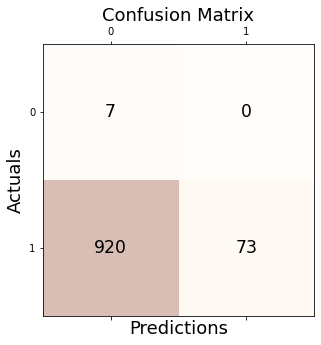

In [464]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [465]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [466]:
print('Accuracy: %.3f' % accuracy_score(outlier_simul_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_simul_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_simul_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_simul_one, outlier_alibi_one))

Accuracy: 0.080
Precision: 1.000
Recall: 0.074
F1 Score: 0.137


### 3. PyNomaly

In [467]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [468]:
m = loop.LocalOutlierProbability(_df[['x', 'y']], use_numba=True, progress_bar=True).fit()
scores = m.local_outlier_probabilities

[ ==================================================================================== ] 100.00%

<AxesSubplot:xlabel='x', ylabel='y'>

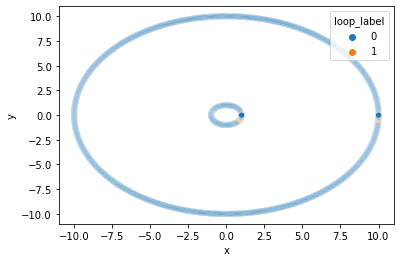

In [469]:
_df['loop_score'] = scores
_df['loop_label'] = _df['loop_score'].apply(lambda x: 1 if x >0.5 else 0)
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'loop_label')

In [470]:
outlier_PyNomaly_one = _df['loop_label']

In [471]:
outlier_PyNomaly_one = list(map(lambda x: 1 if x==0  else -1,outlier_PyNomaly_one))

In [472]:
conf_matrix = confusion_matrix(outlier_simul_one, outlier_PyNomaly_one)

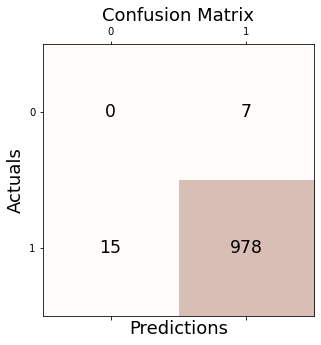

In [473]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [474]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.0

In [475]:
print('Accuracy: %.3f' % accuracy_score(outlier_simul_one, outlier_PyNomaly_one))
print('Precision: %.3f' % precision_score(outlier_simul_one, outlier_PyNomaly_one))
print('Recall: %.3f' % recall_score(outlier_simul_one, outlier_PyNomaly_one))
print('F1 Score: %.3f' % f1_score(outlier_simul_one, outlier_PyNomaly_one))

Accuracy: 0.978
Precision: 0.993
Recall: 0.985
F1 Score: 0.989
